## Solar Disagg Individual Home Tutorial
The SolarDisagg subModule is build on top of the CSSS module and consists primarily of two classes:
- `SolarDisagg_IndvHome`, which follows the training problem outlined in the BuildSys poblication, and 
- `SolarDisagg_IndvHome_Realtime`, which follows the streaming problem outlined in the BuildSys Publication. 

In [1]:
import numpy as np
import pandas as pd
from csss.SolarDisagg import SolarDisagg_IndvHome, SolarDisagg_IndvHome_Realtime
import matplotlib.pyplot as plt
import pytz
import datetime as dt
import pickle as pk
from imp import reload
import copy
import seaborn as sns

% matplotlib inline

In [2]:
def createTempInput(temp, size, minTemp=None, maxTemp=None, intercept = False):
    if (minTemp is None):
        minTemp=min(temp)
    if maxTemp is None:
        maxTemp=max(temp)
    minBound=int(np.floor(minTemp / size)) * size
    maxBound=int(np.floor(maxTemp / size)) * size + size

    rangeCount = int((maxBound-minBound) / size)
    result     = np.zeros((len(temp), rangeCount+intercept))
    t = 0
    for elem in temp:
        fullRanges = min( int(np.floor((elem-minBound) / size)), rangeCount-1)
        fullRanges = max(0, fullRanges)
        bound      = (minBound+fullRanges*size)
        lastRange  = elem-bound
        res        = [size for elem in range(fullRanges)]
        res.append(lastRange)
        for var in range(rangeCount-fullRanges-1):
            res.append(0)
        if intercept:
            res.append(1)  ## Include an intercept
                
            
        result[t,:] = np.array(res)
        t +=1
    return minTemp, maxTemp,result

In [22]:
## Load data and prepare regressors. 
tutorial_data = pk.load( open( "data/tutorial_data.pkl", "rb" ) )

Tmin, Tmax, temp_regress = createTempInput(tutorial_data['temperature'].values, 10)
hod          = pd.Series([t.hour for t in tutorial_data['times']])
hod          = np.array(pd.get_dummies(hod))

loadregressors = np.hstack([hod,temp_regress])
tuneregressors = hod
netload        = tutorial_data['netload']
solarproxy     = tutorial_data['solarproxy']
names          = ['solar_%d' % d for d in np.arange(netload.shape[1])+1]
print(names)

['solar_1', 'solar_2', 'solar_3', 'solar_4', 'solar_5', 'solar_6', 'solar_7', 'solar_8']


In [24]:
tutorial_data

{'times': DatetimeIndex(['2015-03-29 00:00:00-05:00', '2015-03-29 00:15:00-05:00',
                '2015-03-29 00:30:00-05:00', '2015-03-29 00:45:00-05:00',
                '2015-03-29 01:00:00-05:00', '2015-03-29 01:15:00-05:00',
                '2015-03-29 01:30:00-05:00', '2015-03-29 01:45:00-05:00',
                '2015-03-29 02:00:00-05:00', '2015-03-29 02:15:00-05:00',
                ...
                '2015-12-17 21:30:00-06:00', '2015-12-17 21:45:00-06:00',
                '2015-12-17 22:00:00-06:00', '2015-12-17 22:15:00-06:00',
                '2015-12-17 22:30:00-06:00', '2015-12-17 22:45:00-06:00',
                '2015-12-17 23:00:00-06:00', '2015-12-17 23:15:00-06:00',
                '2015-12-17 23:30:00-06:00', '2015-12-17 23:45:00-06:00'],
               dtype='datetime64[ns, America/Chicago]', name='time', length=960, freq=None),
 'solartruth': array([[0.008     , 0.005     , 0.01513333, ..., 0.        , 0.        ,
         0.        ],
        [0.008     , 0.005 

There are 8 net load measurements, corresponding to 8 different meters. There are also 3 solar proxy measurements.

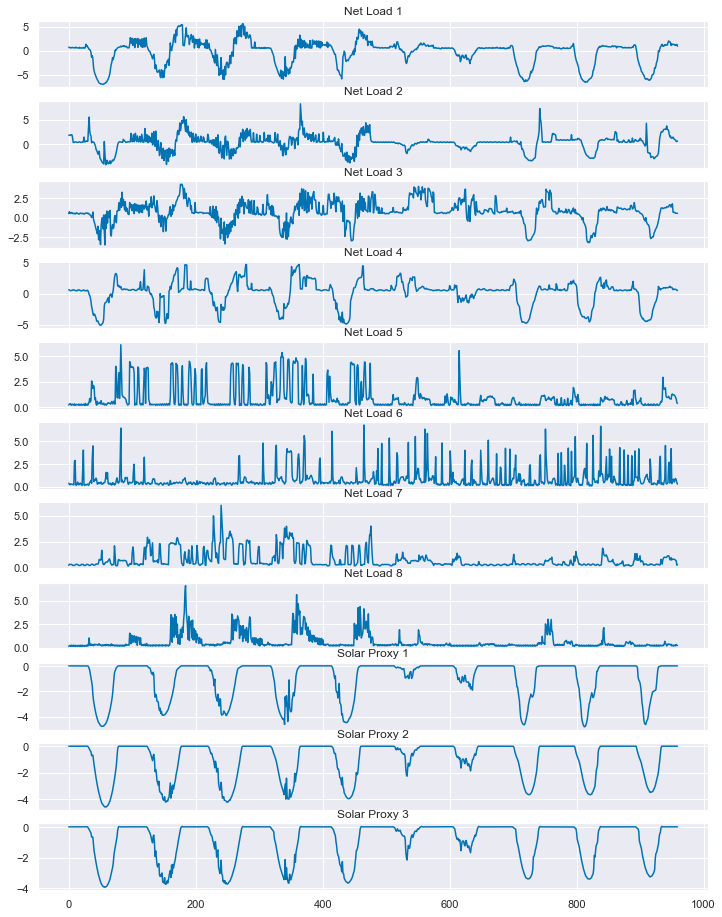

In [4]:
fig, ax = plt.subplots(nrows=11, figsize=(12, 16), sharex=True)
for i in range(11):
    if i < 8:
        ax[i].plot(netload.T[i])
        ax[i].set_title('Net Load {}'.format(i+1))
    else:
        ax[i].plot(solarproxy.T[i-8])
        ax[i].set_title('Solar Proxy {}'.format(i-8+1))

In [5]:
## Create an initial model with equally weighted sources
sdmod0 = SolarDisagg_IndvHome(netloads=netload,                ## Matrix of net loads at each meter
                              solarregressors=solarproxy,      ## X_i for all i
                              loadregressors=loadregressors,   ## X_L 
                              tuningregressors=tuneregressors, ## X_tune
                              names = names)                   ## Optional list of names for solar generation behind each meter. 
## The class initialization builds upon the CSSS class
## It creates N+1 sources, N for solar and 1 for aggregate load
## It constrains solar ot be negative and less than net load
## It constrains aggregate load to be positive. 


## Add true solar values for, at least, the tuning system:
## These are used for evaluating performance metrics and for tuning
for d in range(8):
    source_name = 'solar_%d' % (d+1)
    sdmod0.addTrueValue(name=source_name, trueValue=tutorial_data['solartruth'][:,d])


## Construct and solve the problem. 
sdmod0.constructSolve()              ## Construct and solve the initial problem with flat alphas
sdmod_tune = copy.deepcopy(sdmod0)   ## Make a copy to save the initial problem

## Fit models to predict expected variance of errors given tuning regressors ***
# *********** *********** *********** *********** *********** *********** ******
sdmod_tune.fitTuneModels(            
    tuneSys=['solar_%s' % d for d in [1,2]]  ## Systems used for tuning must have true values loaded
    ) 
## This method adds two methods to the overall class, both are instances of scikitlearn.linear_models.LinearRegression()
# self.Solar_var_norm() is a LinearRegression model predicting normalized variance of errors in solar models from the tuning regressors
# self.Total_NL_var() predicts the variance of errors of the total net load model

## fitTuneModels() also adds varaince lower bounds to each model dictionary under the key 'var_lb'. 

## Use the models to find tuned values of alpha. *******************************
# *********** *********** *********** *********** *********** *********** ******
sdmod_tune.tuneAlphas()              
## tuneAlphas() uses the models fit in fitTuneModels() to tune the alpha values for the entire problem. 

sdmod_tune.constructSolve()          ## Construct and solve the tuned model. 


/Users/bennetmeyers/.virtualenvs/csss/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


0.9934671568479945

In [6]:
## Real Time Problem. *********************************
## ****************************************************

aggregateNetLoad = np.sum(netload, axis = 1)
## The real time problem class is build with a fit training model class as an input. 

sdmod_st_train = SolarDisagg_IndvHome_Realtime(
    sdmod_tune,                        ## Training Model
    aggregateNetLoad=aggregateNetLoad, ## Streaming aggregate net load from substation
    solarregressors=solarproxy,        ## Streaming Solar Proxy
    loadregressors=loadregressors,     ## Streaming Load Regressors
    tuningregressors= tuneregressors  ## Streaming Tuning Regressors
)
    
sdmod_st_train.tuneAlphas()     ## We can tune Alphas because the tuning models were fit in the training problem. 
sdmod_st_train.constructSolve() ##  Solve it!
 

0.9721304612570345

In [15]:
sdmod_st_train.models['AggregateLoad']['alpha']

array([2.36863390e-04, 2.36863390e-04, 2.36863390e-04, 2.36863390e-04,
       2.58129185e-04, 2.58129185e-04, 2.58129185e-04, 2.58129185e-04,
       4.53158333e-04, 4.53158333e-04, 4.53158333e-04, 4.53158333e-04,
       5.34114146e-04, 5.34114146e-04, 5.34114146e-04, 5.34114146e-04,
       3.68118896e-04, 3.68118896e-04, 3.68118896e-04, 3.68118896e-04,
       2.09527045e-04, 2.09527045e-04, 2.09527045e-04, 2.09527045e-04,
       2.65933713e-04, 2.65933713e-04, 2.65933713e-04, 2.65933713e-04,
       2.66967078e-04, 2.66967078e-04, 2.66967078e-04, 2.66967078e-04,
       9.30623430e-04, 9.30623430e-04, 9.30623430e-04, 9.30623430e-04,
       1.52730592e-04, 1.52730592e-04, 1.52730592e-04, 1.52730592e-04,
       1.26267951e-04, 1.26267951e-04, 1.26267951e-04, 1.26267951e-04,
       8.76291264e-05, 8.76291264e-05, 8.76291264e-05, 8.76291264e-05,
       2.13015235e-04, 2.13015235e-04, 2.13015235e-04, 2.13015235e-04,
       1.81137760e-04, 1.81137760e-04, 1.81137760e-04, 1.81137760e-04,
      